**Setup & Mount Drive**

In [1]:
# Colab-specific setup
!pip install torch torchvision pycocotools --quiet
!pip install torchmetrics==1.3.0 # Moved this installation here

from google.colab import drive
drive.mount('/content/drive')

import os
import glob
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision.ops import box_iou

# Paths (update as needed)
TRAIN_BASE_DIR   = '/content/drive/MyDrive/nagarjun/train'
TEST_BASE_DIR   = "/content/drive/MyDrive/nagarjun/test"

TRAIN_IMG_DIR    = TRAIN_BASE_DIR
TRAIN_LABEL_DIR  = TRAIN_BASE_DIR

TEST_IMG_DIR    = TEST_BASE_DIR
TEST_LABEL_DIR  = TEST_BASE_DIR

print(f"Found {len(glob.glob(os.path.join(TRAIN_IMG_DIR, '*.jpg')))} images")
print(f"Found {len(glob.glob(os.path.join(TRAIN_LABEL_DIR, '*.txt')))} label files")

print(f"Found {len(glob.glob(os.path.join(TEST_IMG_DIR, '*.jpg')))} images")
print(f"Found {len(glob.glob(os.path.join(TEST_LABEL_DIR, '*.txt')))} label files")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.3 MB/s eta 0:00:00
Reason for being yanked: <none given>
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 15.4 MB/s eta 0:00:00
Mounted at /content/drive
Found 25 images
Found 25 label files
Found 5 images
Fou

**Dataset Class & Visualization**

Dataset size: 25
Sample boxes: tensor([[  8.3902, 134.0002, 191.5770, 297.6098],
        [189.4795, 130.5042, 367.0729, 284.3251],
        [366.3737, 140.9918, 543.9672, 303.2031],
        [543.2684, 140.2929, 725.7562, 300.4067],
        [724.3578, 138.8941, 859.3013, 299.0079]]) labels: tensor([1, 1, 1, 1, 1])


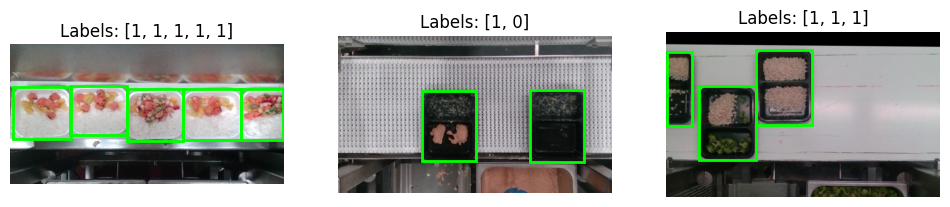

In [2]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms.functional as F
from torchvision.transforms.functional import to_tensor # Import to_tensor

class BowlDataset(Dataset):
    def __init__(self, img_dir, label_dir, transforms=None):
        self.img_paths   = sorted(glob.glob(os.path.join(img_dir, '*.jpg')))
        self.label_dir   = label_dir
        self.transforms  = transforms

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        # Load image
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")
        w, h = img.size

        # Load labels
        label_path = os.path.join(self.label_dir, os.path.basename(img_path).replace('.jpg','.txt'))
        boxes, labels = [], []
        with open(label_path) as f:
            for line in f:
                cls, xc, yc, bw, bh = map(float, line.strip().split())
                # Convert normalized to absolute:
                x1 = (xc - bw/2) * w
                y1 = (yc - bh/2) * h
                x2 = (xc + bw/2) * w
                y2 = (yc + bh/2) * h
                boxes.append([x1, y1, x2, y2])
                labels.append(int(cls))
        boxes  = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels}

        if self.transforms:
            img, target = self.transforms(img, target)

        # return F.to_tensor(img), target
        return img, target


# Instantiate and preview
ds = BowlDataset(TRAIN_IMG_DIR, TRAIN_LABEL_DIR)
# test_ds = BowlDataset(TEST_IMG_DIR, TEST_LABEL_DIR)

print("Dataset size:", len(ds))
img, tgt = ds[0]
print("Sample boxes:", tgt["boxes"], "labels:", tgt["labels"])

# Visualize a few samples
fig, axes = plt.subplots(1, 3, figsize=(12,4))
for ax, i in zip(axes, [0,5,10]):
    im, tgt = ds[i]
    im = to_tensor(im)
    im = im.permute(1,2,0).numpy()
    ax.imshow(im)
    for box in tgt["boxes"]:
        x1,y1,x2,y2 = box
        ax.add_patch(plt.Rectangle((x1,y1), x2-x1, y2-y1,
                                   fill=False, edgecolor='lime', linewidth=2))
    ax.set_title(f"Labels: {tgt['labels'].tolist()}")
    ax.axis('off')
plt.show()


**5-Fold Cross-Validation Split & DataLoaders**

In [7]:
import torch
from torch.utils.data import Subset, DataLoader
from sklearn.model_selection import KFold

# Simple collate_fn to handle variable-size targets
def collate_fn(batch):
    return tuple(zip(*batch))

# Prepare 5-fold split
num_folds = 4
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
splits = list(kf.split(ds))  # ds is our BowlDataset instance

print(f"Prepared {num_folds} folds, each with train/val indices.")

Prepared 4 folds, each with train/val indices.


**Model Definition & Helper Functions**

In [8]:
!pip install torchmetrics==1.3.0 --quiet
import random
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torchvision.ops import generalized_box_iou
import torchvision.transforms.functional as TF
from torchvision.transforms import ColorJitter
from torchvision.models.detection.rpn import AnchorGenerator

# --- 1. A Compose that handles (img, target) pairs ---
class ComposeTransforms:
    def __init__(self, transforms):
        self.transforms = transforms
    def __call__(self, img, target):
        for t in self.transforms:
            img, target = t(img, target)
        return img, target

# --- 2. Per‐sample transforms ---
def random_hflip(img, target, p=0.5):
    if random.random() < p:
        img = TF.hflip(img)
        w, _ = img.size
        boxes = target["boxes"].clone()
        # flip x coords: x1→w−x2, x2→w−x1
        boxes[:, [0,2]] = w - boxes[:, [2,0]]
        target["boxes"] = boxes
    return img, target

def color_jitter(img, target):
    jitter = ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2)
    img = jitter(img)
    return img, target

def to_tensor(img, target):
    return TF.to_tensor(img), target

# --- 3. Build the transform pipeline ---
def get_transform(train: bool):
    transforms = []
    if train:
        transforms.append(lambda img, tgt: random_hflip(img, tgt, p=0.5))
        transforms.append(color_jitter)
        # (you can later add custom random_crop, rotations, etc.)
    transforms.append(to_tensor)
    return ComposeTransforms(transforms)


# --- 4. Model factory ---
def get_fasterrcnn_model(num_classes=2):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, rpn_anchor_generator=anchor_gen)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# --- 5. GIoU loss helper ---
def compute_giou_loss(outputs, targets):
    loss = 0.0
    for out, tgt in zip(outputs, targets):
        # pairwise GIoU matrix
        giou = generalized_box_iou(out["boxes"], tgt["boxes"])
        # assume 1:1 matching by index
        diag = torch.diagonal(giou, 0)
        loss += (1 - diag).mean()
    return loss

# Simple training loop for one epoch
# def train_one_epoch(model, optimizer, loader, device, epoch):
#     model.train()
#     total_loss = 0.0
#     for images, targets in loader:
#         images  = [img.to(device) for img in images]
#         targets = [{k: v.to(device) for k,v in t.items()} for t in targets]

#         loss_dict = model(images, targets)
#         losses = sum(loss for loss in loss_dict.values())
#         total_loss += losses.item()

#         optimizer.zero_grad()
#         losses.backward()
#         optimizer.step()

#     avg_loss = total_loss / len(loader)
#     print(f"Epoch {epoch} — avg training loss: {avg_loss:.4f}")

# training loop to include GIoU
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.train()
    total_loss = 0.0

    for images, targets in loader:
        images  = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k,v in t.items()} for t in targets]

        # 1) Default Faster-RCNN losses
        loss_dict = model(images, targets)
        loss_cls = loss_dict["loss_classifier"]
        loss_box = loss_dict["loss_box_reg"]

        # 2) Forward again (no grad) to get bboxes for GIoU
        # Temporarily switch to evaluation mode to call the model without targets
        model.eval()
        with torch.no_grad():
            outputs = model(images)
        # Switch back to training mode
        model.train()

        # 3) Compute GIoU
        loss_giou = compute_giou_loss(outputs, targets)

        # 4) Total loss = cls + box + α·GIoU
        # Scale down GIoU loss contribution to avoid dominance
        loss = loss_cls + loss_box + 0.5 * loss_giou # Reduced GIoU weight

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    print(f"Epoch {epoch} — avg training loss: {avg_loss:.4f}")


# Evaluation loop using torchmetrics’ MeanAveragePrecision
def evaluate(model, loader, device, iou_thresholds=[0.5]):
    model.eval()
    metric = MeanAveragePrecision(iou_thresholds=iou_thresholds)  # e.g. [0.5] for mAP@0.5
    with torch.no_grad():
        for images, targets in loader:
            images  = [img.to(device) for img in images]
            outputs = model(images)
            # move everything to CPU for metric
            outputs = [{k: v.cpu() for k,v in t.items()} for t in outputs]
            targets = [{k: v.cpu() for k,v in t.items()} for t in targets]
            metric.update(outputs, targets)
    return metric.compute()


**Train & Validate Across Folds**

In [9]:
import torch
import numpy as np # Ensure numpy is imported if needed elsewhere
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image
from torchvision.ops import box_iou
import random
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

if torch.cuda.is_available():
  device = torch.device("cuda")
  print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
  device = torch.device("cpu")
  print("Using CPU")
num_epochs = 30

all_map50    = []
all_map5095  = []

test_ds = BowlDataset(TEST_IMG_DIR, TEST_LABEL_DIR,
                     transforms=get_transform(False))

# --- Variables to track the overall best model across all folds ---
best_overall_validation_mAP = 0.0 # Initialize with a value lower than any expected mAP
best_overall_model_state = None
# -----------------------------------------------------------------

for fold, (train_idx, val_idx) in enumerate(splits, 1):
    print(f"\n── Fold {fold}/{num_folds} ──")

    # # Subsets and loaders
    # train_ds = Subset(ds, train_idx)
    # val_ds   = Subset(ds, val_idx)

    train_ds = Subset(
        BowlDataset(TRAIN_IMG_DIR, TRAIN_LABEL_DIR, transforms=get_transform(True)),
        train_idx
    )
    val_ds   = Subset(
        BowlDataset(TRAIN_IMG_DIR, TRAIN_LABEL_DIR, transforms=get_transform(False)),
        val_idx
    )

    # Inspecting Fold for leakage
    train_files = { ds.img_paths[i] for i in train_idx }
    val_files   = { ds.img_paths[i] for i in val_idx }
    print("Overlap:", train_files & val_files)   # should be empty

    train_loader = DataLoader(train_ds, batch_size=4, shuffle=True,  collate_fn=collate_fn)
    val_loader   = DataLoader(val_ds,   batch_size=2, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_ds, batch_size=2, shuffle=False, collate_fn=collate_fn)

    # Model, optimizer, scheduler
    model = get_fasterrcnn_model(num_classes=2).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    # Train
    for epoch in range(1, num_epochs+1):
        train_one_epoch(model, optimizer, train_loader, device, epoch)
        lr_scheduler.step()

    # Eval @ IoU=0.5
    res50   = evaluate(model, val_loader, device, iou_thresholds=[0.5])
    # Eval @ IoU=0.5:0.95 CEils
    res5095 = evaluate(model, val_loader, device, iou_thresholds=[x/100 for x in range(50, 96, 5)])

    mAP50   = res50["map_50"].item()     if "map_50" in res50 else res50["map"].item()
    mAP5095 = res5095["map"].item()

    print(f"Fold {fold} results → mAP@0.5: {mAP50:.3f}, mAP@[0.5:0.95]: {mAP5095:.3f}")

    # --- Check if this model is the overall best so far ---
    if mAP50 > best_overall_validation_mAP:
        best_overall_validation_mAP = mAP50
        # Save the model's state dictionary
        best_overall_model_state = model.state_dict()
        print(f"  --> New overall best mAP@0.5 found: {best_overall_validation_mAP:.3f}. Model state saved.")

    all_map50.append(mAP50)
    all_map5095.append(mAP5095)

# Summarize cross-val performance
import numpy as np
print(f"\n📊 Cross-val mAP@0.5:    {np.mean(all_map50):.3f} ± {np.std(all_map50):.3f}")
print(f"📊 Cross-val mAP@0.5:0.95 {np.mean(all_map5095):.3f} ± {np.std(all_map5095):.3f}")


# --- Load the best model after all folds are complete ---
best_model = get_fasterrcnn_model(num_classes=2).to(device)
if best_overall_model_state is not None:
    best_model.load_state_dict(best_overall_model_state)

    print(f"\nLoaded the overall best model with validation mAP@0.5: {best_overall_validation_mAP:.3f}")
else:
    print("\nNo best model state saved. Check training process.")


test_res50    = evaluate(best_model, test_loader, device,
                        iou_thresholds=[0.5]        # and/or [0.5:0.95]
                       )
test_res5095 = evaluate(best_model, test_loader, device,
                        iou_thresholds=[x/100 for x in range(50,96,5)])
print("Final held-out mAP@0.5: on test data", test_res50["map_50"].item())
print("Held-out Test mAP@0.5:0.95", test_res5095["map"].item())


# Trained Artifacts
# 1) Save PyTorch weights
torch.save(best_model.state_dict(), 'fasterrcnn_bowl_best.pth')

!pip install onnx --quiet # Install ONNX
# 2) Export to ONNX
dummy_input = torch.randn(1, 3, 480, 640).to(device)
torch.onnx.export(
    best_model, dummy_input, 'bowl_detector.onnx',
    input_names=['input'],
    output_names=['boxes','scores','labels'],
    dynamic_axes={
      'input': {0:'batch'},
      'boxes': {0:'batch'}, 'scores':{0:'batch'}, 'labels':{0:'batch'}
    },
    opset_version=12
)
print("✅ Exported ONNX → bowl_detector.onnx")

Using GPU: NVIDIA A100-SXM4-40GB

── Fold 1/4 ──
Overlap: set()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1 — avg training loss: 3.5539
Epoch 2 — avg training loss: 2.6223
Epoch 3 — avg training loss: 2.6401
Epoch 4 — avg training loss: 2.5581
Epoch 5 — avg training loss: 2.2389
Epoch 6 — avg training loss: 2.1162
Epoch 7 — avg training loss: 2.2783
Epoch 8 — avg training loss: 2.3247
Epoch 9 — avg training loss: 2.3285
Epoch 10 — avg training loss: 2.3451
Epoch 11 — avg training loss: 2.1530
Epoch 12 — avg training loss: 2.0705
Epoch 13 — avg training loss: 2.0919
Epoch 14 — avg training loss: 2.1403
Epoch 15 — avg training loss: 2.0502
Epoch 16 — avg training loss: 2.1557
Epoch 17 — avg training loss: 1.8483
Epoch 18 — avg training loss: 1.8513
Epoch 19 — avg training loss: 2.1057
Epoch 20 — avg training loss: 2.0789
Epoch 21 — avg training loss: 2.0975
Epoch 22 — avg training loss: 2.1072
Epoch 23 — avg training loss: 2.1358
Epoch 24 — avg training loss: 2.1206
Epoch 25 — avg training loss: 2.1576
Epoch 26 — avg training loss: 2.0657
Epoch 27 — avg training loss: 2.1616
Epoch 28 —

/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:4511: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.tensor(scale_factors[i], dtype=torch.float32)
/usr/local/lib/python3.11/dist-packages/torchvision/ops/boxes.py:166: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes_x = torch.min(boxes_x, torch.tensor(width, dtype=boxes.dtype, device=boxes.device))
/usr/local/lib/python3.11/dist-packages/torchvision/ops/boxes.py:168: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes_y = torch.min(boxes_y, torch.tensor(height, dty

✅ Exported ONNX → bowl_detector.onnx


**Visualizing Predictions vs. Ground Truth**

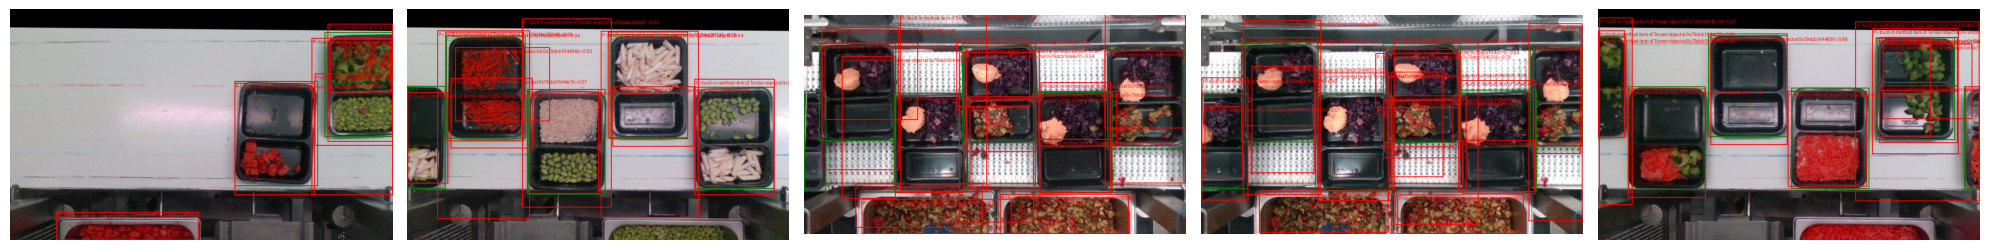

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image
import torch # Ensure torch is imported

def visualize_predictions(model, dataset, device, n_images=5, conf_thresh=0.5):
    model.eval()
    fig, axes = plt.subplots(1, n_images, figsize=(n_images*4, 4))
    for ax, idx in zip(axes, np.random.choice(len(dataset), n_images, replace=False)):
        img, target = dataset[idx]
        with torch.no_grad():
            output = model([img.to(device)])[0]
        # filter by confidence
        keep = output['scores'] > conf_thresh
        preds = {k: v[keep].cpu() for k, v in output.items()}

        # Ensure the image tensor is uint8 and has the correct channel order (C, H, W)
        # The original img tensor from the dataset is already (C, H, W)
        # Convert to uint8 for drawing
        img_uint8 = (img * 255).to(torch.uint8) # Assuming the original img is float [0, 1]

        # draw GT (green) then preds (red)
        drawn = draw_bounding_boxes(
            img_uint8,  # Use the uint8 tensor
            boxes=target['boxes'],
            labels=[f"GT:{l.item()}" for l in target['labels']],
            colors="green", width=2
        )
        drawn = draw_bounding_boxes(
            drawn,
            boxes=preds['boxes'],
            labels=[f"P:{l.item}:{s:.2f}"
                    for l, s in zip(preds['labels'], preds['scores'])],
            colors="red", width=2
        )
        ax.imshow(drawn.permute(1,2,0)) # Permute back for matplotlib
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Example: visualize on your best‐performing fold’s val set
visualize_predictions(model, val_ds, device)


**Plotting Precision–Recall Curves**

mAP@0.5: 0.4732
mAR@100: 0.5000


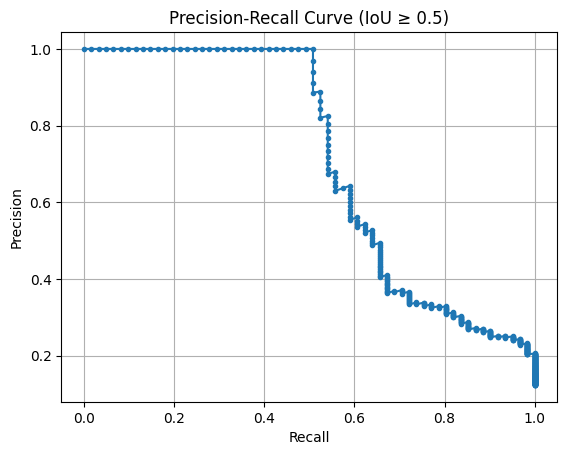

In [11]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from sklearn.metrics import precision_recall_curve
import torch
import matplotlib.pyplot as plt

# 1. Instantiate metric for evaluation
pr_metric = MeanAveragePrecision(iou_type="bbox", iou_thresholds=[0.5])

# Collect raw scores for manual PR curve
all_scores = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, targets in val_loader:
        images = [img.to(device) for img in images]
        outputs = model(images)

        # Move everything to CPU for metric update
        outputs_cpu = [{k: v.cpu() for k, v in o.items()} for o in outputs]
        targets_cpu = [{k: v.cpu() for k, v in t.items()} for t in targets]

        pr_metric.update(outputs_cpu, targets_cpu)

        # For sklearn precision-recall curve (binary classification assumption: class 1 = bowl)
        for out, tgt in zip(outputs_cpu, targets_cpu):
            scores = out['scores'].tolist()
            labels = []

            for pred_box in out['boxes']:
                ious = [box_iou(pred_box.unsqueeze(0), gt_box.unsqueeze(0)).item()
                        for gt_box in tgt['boxes']]
                max_iou = max(ious) if ious else 0.0
                labels.append(1 if max_iou >= 0.5 else 0)

            all_scores.extend(scores)
            all_labels.extend(labels)

# 2. Compute mAP summary
results = pr_metric.compute()
print(f"mAP@0.5: {results['map_50']:.4f}")
print(f"mAR@100: {results['mar_100']:.4f}")

# 3. Plot PR Curve using sklearn
precision, recall, _ = precision_recall_curve(all_labels, all_scores)
plt.plot(recall, precision, marker='.')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (IoU ≥ 0.5)")
plt.grid(True)
plt.show()


**Per Image, Side-by-Side Visualization**

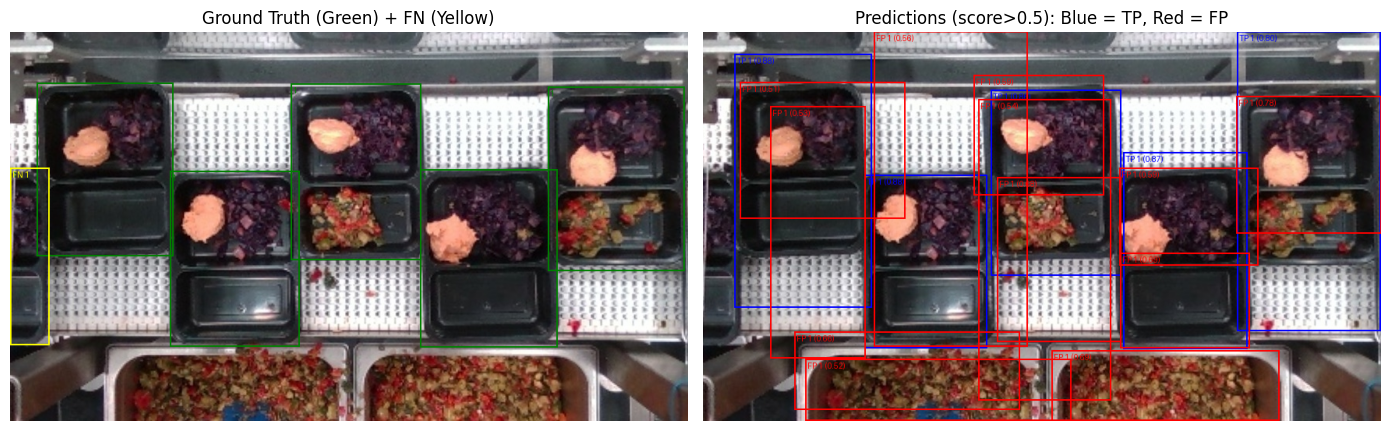

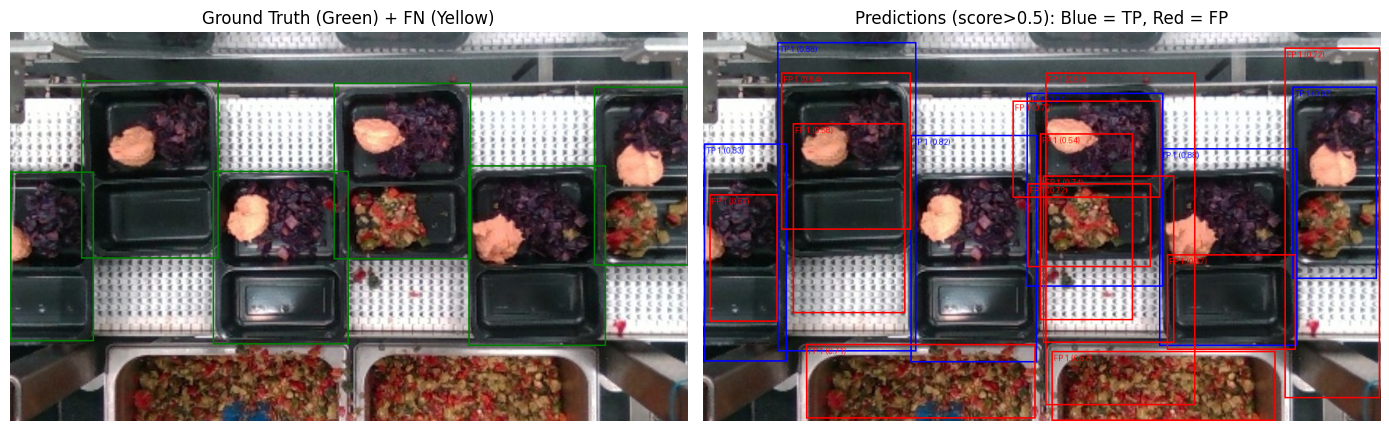

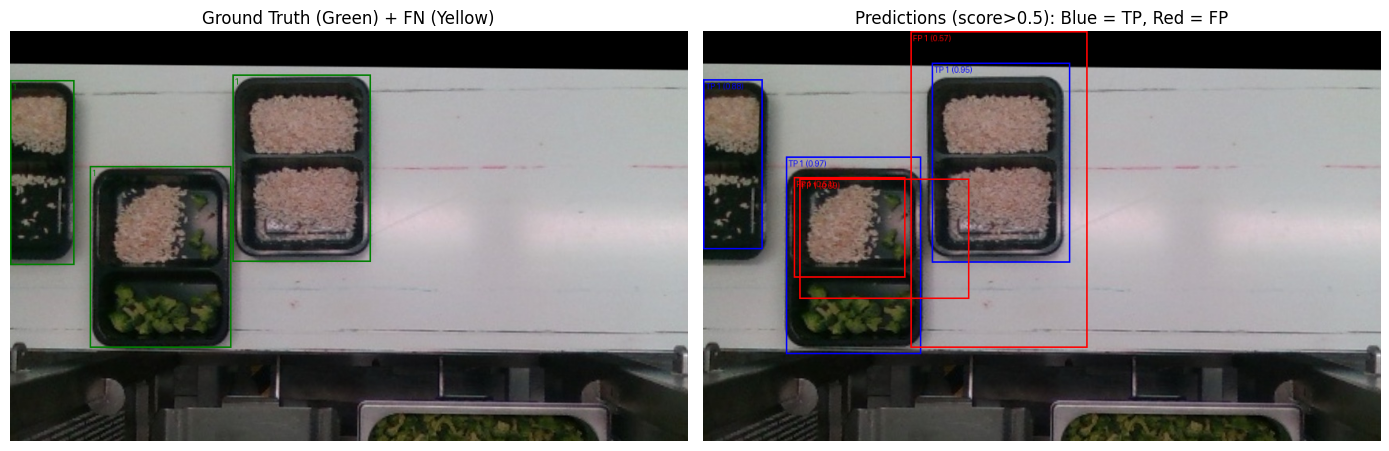

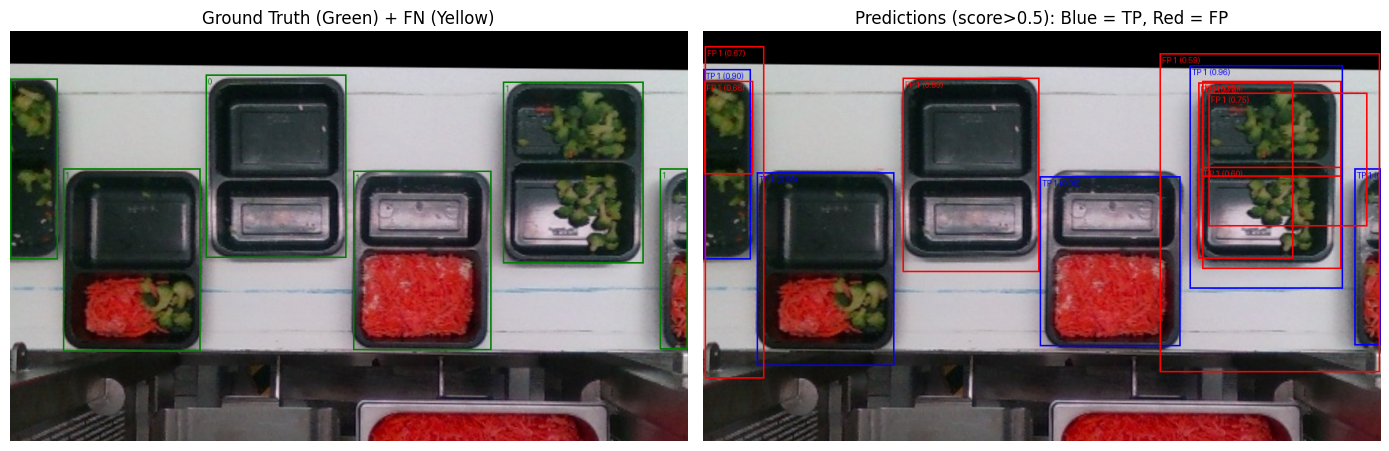

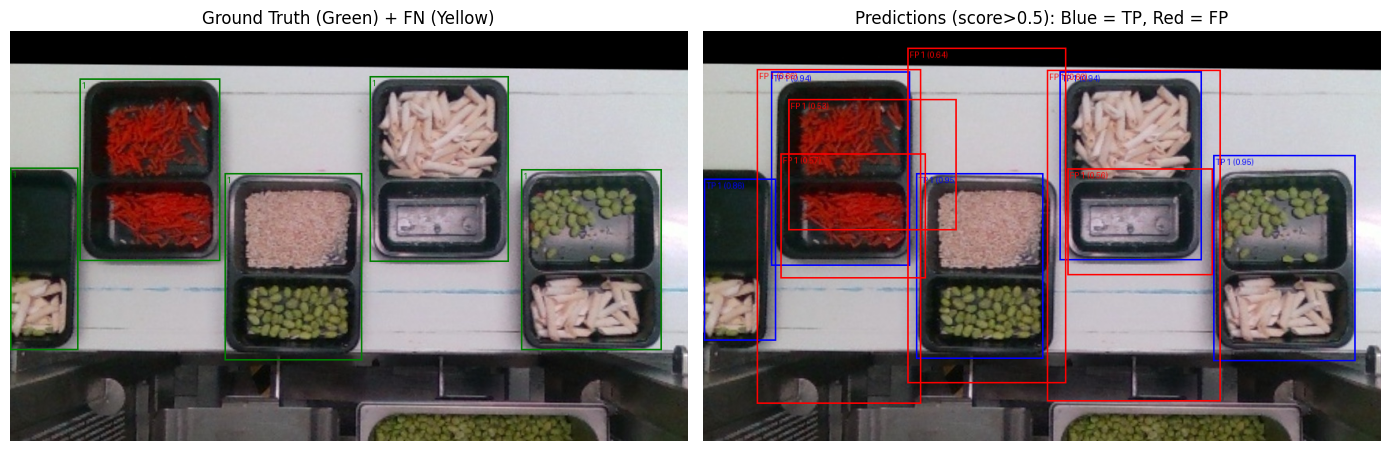

In [12]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image
from torchvision.ops import box_iou
import numpy as np
import random

def match_predictions_to_ground_truth(pred_boxes, pred_labels, pred_scores,
                                       gt_boxes, gt_labels, iou_thresh=0.5):
    """
    Match predicted boxes to ground truth boxes using IoU and return TP, FP, FN with class correctness
    """
    # Handle cases where there are no predictions or no ground truth boxes
    if pred_boxes.numel() == 0 or gt_boxes.numel() == 0:
        tp_boxes, fp_boxes, fn_boxes = [], [], []
        if pred_boxes.numel() > 0: # All predictions are FP if no GT
            fp_boxes = [(pred_boxes[i], pred_labels[i], pred_scores[i]) for i in range(pred_boxes.size(0))]
        if gt_boxes.numel() > 0: # All GT are FN if no predictions
             fn_boxes = [(gt_boxes[i], gt_labels[i]) for i in range(gt_boxes.size(0))]
        return tp_boxes, fp_boxes, fn_boxes


    iou_matrix = box_iou(pred_boxes, gt_boxes)
    matched_gt_indices = set()
    tp_boxes, fp_boxes = [], []

    # Sort predictions by score in descending order for correct matching
    scores_sorted, indices = pred_scores.sort(descending=True)
    pred_boxes_sorted = pred_boxes[indices]
    pred_labels_sorted = pred_labels[indices]


    for pred_idx in range(pred_boxes_sorted.size(0)):
        pred_box = pred_boxes_sorted[pred_idx]
        pred_label = pred_labels_sorted[pred_idx]
        pred_score = scores_sorted[pred_idx]

        # Find the best matching ground truth box
        max_iou, gt_idx = torch.max(iou_matrix[indices[pred_idx]], dim=0)

        # Check if it's a valid match and the GT box hasn't been matched yet
        if max_iou >= iou_thresh and gt_idx.item() not in matched_gt_indices:
            # Check for class correctness
            if pred_label == gt_labels[gt_idx]:
                tp_boxes.append((pred_box, pred_label, pred_score))
            else:
                 # Prediction has sufficient IoU but wrong class -> FP
                fp_boxes.append((pred_box, pred_label, pred_score))
            matched_gt_indices.add(gt_idx.item()) # Mark the GT box as matched
        else:
            # Prediction does not meet IoU threshold or GT is already matched -> FP
            fp_boxes.append((pred_box, pred_label, pred_score))

    fn_boxes = []
    for gt_idx in range(gt_boxes.size(0)):
        if gt_idx not in matched_gt_indices:
            fn_boxes.append((gt_boxes[gt_idx], gt_labels[gt_idx]))

    return tp_boxes, fp_boxes, fn_boxes

def visualize_predictions_colored(model, val_loader, device, max_samples=5, score_thresh=0.5):
    model.eval()
    sample_count = 0

    with torch.no_grad():
        # Use iter(val_loader) and next() to process one batch at a time if needed,
        # or iterate through the loader normally. Processing one batch at a time
        # can be useful for debugging, but iterating through the loader is standard.
        for images, targets in val_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            for img, pred, target in zip(images, outputs, targets):
                if sample_count >= max_samples:
                    return

                # Ensure the image tensor is uint8 and has the correct channel order (C, H, W)
                img = (img * 255).byte() if img.max() <= 1 else img.byte()
                img = img.cpu()

                pred_boxes = pred['boxes'].cpu()
                pred_scores = pred['scores'].cpu()
                pred_labels = pred['labels'].cpu()

                keep = pred_scores > score_thresh
                pred_boxes = pred_boxes[keep]
                pred_labels = pred_labels[keep]
                pred_scores = pred_scores[keep]

                gt_boxes = target['boxes'].cpu()
                gt_labels = target['labels'].cpu()

                # Match predictions to ground truth
                tp, fp, fn = match_predictions_to_ground_truth(pred_boxes, pred_labels, pred_scores,
                                                               gt_boxes, gt_labels)

                # Draw ground truth (all GT boxes are drawn, FN are highlighted implicitly by no TP prediction)
                # The original gt_boxes tensor is already in the correct format (N, 4)
                gt_img = draw_bounding_boxes(img, gt_boxes, # Corrected line: removed torch.stack()
                                             labels=[str(int(l.item())) for l in gt_labels],
                                             colors="green", width=2)

                # Draw predictions: TP = blue, FP = red
                pred_boxes_to_draw = []
                pred_labels_to_draw = []
                pred_colors = []

                for b, l, s in tp:
                    pred_boxes_to_draw.append(b)
                    pred_labels_to_draw.append(f"TP {int(l.item())} ({s:.2f})")
                    pred_colors.append("blue")
                for b, l, s in fp:
                    pred_boxes_to_draw.append(b)
                    pred_labels_to_draw.append(f"FP {int(l.item())} ({s:.2f})")
                    pred_colors.append("red")

                # Add FN boxes to the ground truth visualization for clarity
                fn_boxes_to_draw = [b for b,l in fn]
                fn_labels_to_draw = [f"FN {int(l.item())}" for b,l in fn]

                if fn_boxes_to_draw:
                     # Stack FN boxes to draw them (if any exist)
                     # Use 'yellow' for FN to make them stand out
                    gt_img = draw_bounding_boxes(gt_img, torch.stack(fn_boxes_to_draw),
                                                 labels=fn_labels_to_draw, colors="yellow", width=2)


                if pred_boxes_to_draw:
                    pred_img = draw_bounding_boxes(img, torch.stack(pred_boxes_to_draw),
                                                   labels=pred_labels_to_draw, colors=pred_colors, width=2)
                else:
                    pred_img = img

                # Plot side-by-side
                fig, ax = plt.subplots(1, 2, figsize=(14, 7))
                ax[0].imshow(to_pil_image(gt_img))
                ax[0].set_title("Ground Truth (Green) + FN (Yellow)")
                ax[1].imshow(to_pil_image(pred_img))
                ax[1].set_title(f"Predictions (score>{score_thresh}): Blue = TP, Red = FP")
                for a in ax:
                    a.axis("off")
                plt.tight_layout()
                plt.show()

                sample_count += 1

visualize_predictions_colored(model, val_loader, device)